# Data Mining - Handin 2 - Graph mining

This handin corresponds to the topics in Week 10-15 in the course.

The handin is 
* done in the chosen handin groups
* worth 10% of the grade

For the handin, you will prepare a report in PDF format, by exporting the Jupyter notebook. 
Please submit
1. The jupyter notebook file with your answers
2. The PDF obtained by exporting the jupyter notebook

Submit both files on Brightspace no later than **April 21 kl. 11.59PM**.

**The grading system**: Tasks are assigned a number of points based on the difficulty and time to solve it. The sum of
the number of points is **100**. For the maximum grade you need to get at least _80 points_. The minimum grade (02 in the Danish scale)
requires **at least** 30 points, with at least 8 points on of the first three Parts (Part 1,2,3) and 6 points in the last part (Part 4).
Good luck!

**The exercise types**: There are three different types of exercises
1. <span style='color: green'>**\[Compute by hand\]**</span> means that you should provide **NO code**, but show the main steps to reach the result (not all).  
2. <span style='color: green'>**\[Motivate\]**</span> means to provide a short answer of 1-2 lines indicating the main reasoning, e.g., the PageRank of a complete graph is 1/n in all nodes as all nodes are symmetric and are connected one another.
3. <span style='color: green'>**\[Describe\]**</span> means to provide a potentially longer answer of 1-5 lines indicating the analysis of the data and the results. 
4. <span style='color: green'>**\[Prove\]**</span> means to provide a formal argument and NO code. 
5. <span style='color: green'>**\[Implement\]**</span> means to provide an implementation. Unless otherwise specified, you are allowed to use helper functions (e.g., ```np.mean```, ```itertools.combinations```, and so on). However, if the task is to implement an algorithm, by no means a call to a library that implements the same algorithm will be deemed as sufficient! 

In [9]:
### BEGIN IMPORTS - DO NOT TOUCH!
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import sys
sys.path.append('..')
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install networkx
#!{sys.executable} -m pip install torchvision
import random
import scipy.io as sio
import time

import networkx as nx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import csv
from itertools import count


import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from utilities.load_data import load_mnist
import utilities.email as email
from utilities.mnist import *

from utilities.make_graphs import read_edge_list, read_list, load_data

### END IMPORTS - DO NOT TOUCH!

ImportError: cannot import name 'TypeAlias' from 'typing_extensions' (/opt/anaconda3/lib/python3.8/site-packages/typing_extensions.py)

## Task 1.1 Random walks and PageRank  (12 points)

In this exercise recall that the PageRank is defined as 

$$\mathbf{r} = \alpha \mathbf{Mr} + (1-\alpha)\mathbf{p}$$ 

where $\mathbf{r}\in \mathbb{R}^n$ is the PageRank vector, $\alpha$ is the restart probability, $\mathbf{M} = A\Delta^{-1}$, and $\mathbf{p}$ is the restart (or personalization) vector. 

**************************************
### Task 1.1.1 (4 points)
What is the PageRank of a **$d$-regular** graph with $n$ nodes and $\alpha=1$? 

<span style='color: green'>**\[Motivate\]**</span> your answer without showing the exact computation. 

*************************************
PageRank is the importance of the given node. It is obtained by doing a random walk of the graph and seeing how often it takes us to the given node. This is how each get's assigned a value. The value depends on the weight of the incoming nodes through increasing the probability because we are more likely to end up in a well connected node. By definition d-regular graph each node has d connections. 

The other parameter alpha affects the so called teleport. If the random walk get stuck in a spider trap we would jump to a random node. Here it is not possible to jump since alpha in 1.

All the nodes are equally important so the PageRank of one node is d.
*************************************

### Task 1.1.2 (6 points)
Look at the graph below (run the code) and try make a guess about the PageRank values of each node only by reasoning on the graph's connections.

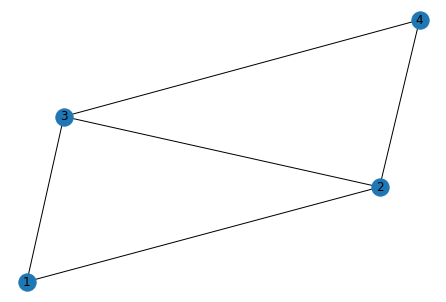

In [13]:
G = nx.Graph()
G.add_edges_from([(1,2),(2,3), (2,4), (3,4), (1,3)])
nx.draw(G, with_labels=True, )

<span style='color: green'>**A) \[Implement\]**</span> the PageRank for $\alpha=1$ for the graph using the Power Iteration method (use $\epsilon=1e-16$ to stop the iteration).<br> 

<span style='color: green'>**B) \[Implement\]**</span> Plot the norm square difference of the $r$ vector (between any two consecutive iterations) for each iteration.

<span style='color: green'>**C) \[Motivate\]**</span> Do you observe a constant decrease of the norm square difference as iterations are increasing, and is this decrease expected or not?

<span style='color: green'>**D) \[Implement\]**</span> the PageRank for $\alpha=1$ using the eigenvector method.<br> 

<span style='color: green'>**E) \[Motivate\]**</span> Are solutions of both methods the same? Why don't we only use the eigenvector method that optimally solves the problem? 

<span style='color: green'>**F) \[Motivate\]**</span> Do the real vector match with your first guess? Can you see a pattern between the pagerank score of each node and its edges?   

In [18]:
#A) YOUR CODE HERE 

import networkx as nx
import numpy as np

adj_matrix = nx.to_numpy_matrix(G)
degree_matrix = np.diag(np.asarray(adj_matrix.sum(axis=1)).flatten())
stochastic_matrix = np.matmul(np.linalg.inv(degree_matrix), adj_matrix)

n = G.number_of_nodes()
pagerank = np.ones((n,1)) / n
tol = 1e-16

while True:
    new_pagerank = np.matmul(stochastic_matrix, pagerank)
    if np.linalg.norm(new_pagerank - pagerank, ord=1) < tol:
        break
    pagerank = new_pagerank

for i, pr in enumerate(pagerank):
    print(f"PageRank of node {i+1} is {pr[0]:.6f}")

PageRank of node 1 is 0.250000
PageRank of node 2 is 0.250000
PageRank of node 3 is 0.250000
PageRank of node 4 is 0.250000


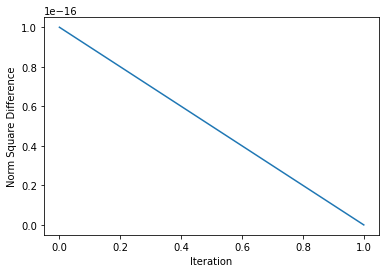

PageRank of node 1 is 0.250000
PageRank of node 2 is 0.250000
PageRank of node 3 is 0.250000
PageRank of node 4 is 0.250000


In [23]:
#B) YOUR CODE HERE 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

adj_matrix = nx.to_numpy_matrix(G)
degree_matrix = np.diag(np.asarray(adj_matrix.sum(axis=1)).flatten())
stochastic_matrix = np.matmul(np.linalg.inv(degree_matrix), adj_matrix)

n = G.number_of_nodes()
pagerank = np.ones((n,1)) / n
tol = 1e-16

norm_diff_list = []
norm_diff = np.linalg.norm(pagerank - pagerank, ord=2) ** 2
if norm_diff < tol:
    norm_diff_list.append(epsilon)

while True:
    new_pagerank = np.matmul(stochastic_matrix, pagerank)
    norm_diff = np.linalg.norm(new_pagerank - pagerank, ord=2) ** 2
    norm_diff_list.append(norm_diff)
    if norm_diff < tol:
        break
    pagerank = new_pagerank
    
plt.plot(norm_diff_list)
plt.xlabel('Iteration')
plt.ylabel('Norm Square Difference')
plt.show()

for i, pr in enumerate(pagerank):
    print(f"PageRank of node {i+1} is {pr[0]:.6f}")

<span style="color:red"> C) The decrease is constant. This decrease is expected as the number of iterations increase as the power iteration method has been designed such that it converges to the PageRank vector. As the program approaches this vector, the norm square difference between each iteration is expected to decrease. </span>


In [24]:
#D) YOUR CODE HERE

def my_pagerank_eigenvector(G, alpha=1):
    A = nx.adjacency_matrix(G).toarray()
    n = len(G.nodes())

    d = np.sum(A, axis=1)
    M = A / d[:, np.newaxis]
    M = np.nan_to_num(M)

    I = np.identity(n)
    v = np.ones(n) / n
    M_hat = alpha * M + (1 - alpha) * np.ones((n,n)) / n
    w, v = np.linalg.eig(M_hat.T)
    idx = np.argmax(w)
    pagerank = v[:,idx].real
    pagerank /= sum(pagerank)

    return pagerank

pagerank = my_pagerank_eigenvector(G)
print(pagerank)

[0.2 0.3 0.3 0.2]


<span style="color:red"> E) The solutions are not the same. The power iteration method is faster and takes up less memory space compared to the eigenvector, hence is better for larger graphs.  </span>

<span style="color:red"> F) Yes it does. I had guessed a higher pagerank for node 2 & 3 as they have 3 edges connected to each of them compared to 1 & 4 which have two edges connected to each of them. The higher the pagerank score, the greater the number of edges a node has. </span>

### Task 1.1.3 (2 points)

<span style='color: green'>**\[Motivate\]**</span><br>

Assume you have embedded the graph in **1.1.2** with a __Linear Embedding__ using unormalized Laplacian matrix of the graph as the similarity matrix. How do you expect the embeddings to be if the embedding dimension is $d = 1$?
(1) Check the correct box below and (2) motivate your answer.

* [ ] Nodes 1, 2, 3, 4 will be placed in the corners of a hypercube
* [ ] Nodes 2,3 will have the same embedding while 1,4 will be far from each other.
* [x] Nodes 1,4 and 2,3 will have very close embeddings.
* [ ] Nodes 3,4 will be very far apart.

<font color='red'>IMPORTANT: Do NOT just choose one answer. Please clarify WHY this is the correct answer.</font>

******************
<span style="color:red">As there are no nodes with zero degree and the graph has only one connected component, the first eigenvector in the Laplacian matrix will be a constant vector. Hence, we use the second smallest eigenvector which is the Fiedler vector. The cutpoints are the edges (1,2) and (2,4), thus 2 and 3 will have the same embedding since they belong in the same set are connected by an edge. As 1 and 4 are connected by an edge and belong in the same set (different than 2 and 3) as well, they too will have very close embeddings.</span>
******************

## Task 1.2: Spectral Properties of the Graph Laplacian (17 points)
 <span style='color: green'>**\[Prove\]**</span> **the following properties:**
 You will be given points for each of the properties that you prove, rather than points for the exercise as a whole.

**Note that all question correspond to the eigenvalues of the LAPLACIAN (NOT THE NORMALIZED)**

For a graph with $n$ nodes the eigenvalues of the LAPLACIAN ($L  = D - A$) is sorted in ascending order, i.e.,<br>
**$\lambda_0\leq\lambda_1\leq...\leq\lambda_{n-1}$**

### Task 1.2.1 (1 points)

For all graphs $\lambda_0 = 0$ 

*******************
By definition we can find the eigenvalues on a given matrix by the equation $(L-\lambda I)=0$.
These eigenvalues are a solution to the eigenvector $v$ equation that can be written $Lv=\lambda v$. The Laplacian matrix can be is build by:

$L=\begin{cases} deg(n_{ij}) &,\text{if} \; i=j \\ -1 &,\text{if} \; i\neq j \;\text{and nodes are adjacent}\\ 0 &, \text{otherwise}
\end{cases}$

As the degree of a node is the connection is has then the sum of each column and row is 0. There are always as many -1 elements as the degree is. 

Because of this there is always an eigenvector $v_0=(1,1,...,1)$ that corresponds to the eigenvalue $\lambda_0=0$ because these fulfill the eigenvector equation. This is because the right side of the eqution picks out the sum of each row into a vector. 

$L v_0=(0 \; 0 \; 0 ... 0 )^T$

This means that the corresponding eigenvalue is also 0.

$Lv=\lambda v$

$\Rightarrow (0 \; 0 \; 0 ... 0 )^T=(\lambda \; \lambda \; \lambda ... \lambda )^T$

$\Rightarrow \; \lambda = 0$

And as we have chosen the eigenvalues to be ascending it is always with the lowest index.
******************

### Task 1.2.2 (2 points)
For the complete graph, $\lambda_1, \dots, \lambda_{n-1} = n$

******************
A coplete graph is one where all the nodes are connected so it is like this:

$L=\left( \begin{matrix}
n-1 & -1 & \dots & -1 \\
-1 & n-1 & \dots & -1 \\
\vdots & & \ddots & \vdots \\
-1 &  \dots & -1 & n-1
\end{matrix} \right)$

We can find the eigenvalues solving the equation $(L-\lambda I)=0$:

$\left| \left( \begin{matrix}
n-1-\lambda & -1 & \dots & -1 \\
-1 & n-1-\lambda & \dots & -1 \\
\vdots & & \ddots & \vdots \\
-1 &  \dots & -1 & n-1-\lambda
\end{matrix} \right) \right|=0$

Calculating the determinant is simple and can be sone by taking the sub-determinants. As an example in the case $n=3$:

$\left| \left( \begin{matrix}
2-\lambda & -1  & -1 \\
-1 & 2-\lambda & -1 \\
-1 & -1 & 2-\lambda
\end{matrix} \right) \right|=(2-\lambda)((2-\lambda)^2-1)+1(-(2-\lambda)-1))-1((2-\lambda)+1))=0$

$(\lambda -3)^2\lambda = 0$

So as in the previous question we see that the first eigenvalue is 0. The other ones are degenarate. The equation will always come to that form and give that the $\lambda_1, \dots, \lambda_{n-1} = n$ in $n$-dimensional case.

******************

### Task 1.2.3 (3 points)

For all the graphs with $k$ connected components $\lambda_0 = \lambda_1 =...=\lambda_ k = 0$

******************
Since the Laplacian matrix L is symmetric and positive semi-definite, all its eigenvalues are non-negative. Since the graph has k connected components, L can be expressed as a k block diagonal matrix with k blocks corresponding to the respective connected components. Let L1, L2, ... , Lk be the Laplacian matrices of the k blocks. We can see that the eigenvalues of L is hence the union set of the respective eigenvalues of the individual L1, L2, ..., Lk of the k components. Since each component has at least one node, its respective Laplacian matrix will contain an eigenvalue 0 corresponding to its constant vector of 1's. Thus, each block will have eigenvalue 0 and $\lambda_0 = \lambda_1 =...=\lambda_ k = 0$.

******************

### Task 1.2.4 (5 points)
Given a graph $G$ with eigenvalues of the laplacian $\lambda_0, \lambda_1,...,\lambda_{n-1}$.<br>
We randomly remove an edge from $G$ and we re-calculate the eigenvalues as $\lambda'_0, \lambda'_1,...,\lambda'_{n-1}$.<br>
Can we have $\lambda'_{i}>\lambda_{i}$ for some $0\leq i\leq n-1$? Why? Why not?

******************
Laplacian matrix of a graph G: L=D-A; D is the diagonal matrix of vertex degrees & A is the adjacency matrix. Removing an edge from G, we obtain the new adjacency matrix A' by subtracting the corresponding entry from the original adjacency matrix A. This will change L to L' = D - A'. Assuming that the edge removed connects vertices i and j in G, the corresponding entries in the adjacency matrix A were A[i][j] = 1 and A[j][i] = 1.

L' can be written as L' = D - A' = D - (A - E[i][j] - E[j][i]), where E[i][j] and E[j][i] have all entries zero except for a 1 in the (i,j) and (j,i) positions, respectively.

Let's assume that the eigenvalue $\lambda_i$ is the i-th smallest eigenvalue of L. Then, $\lambda'_i = \lambda_i$ + d, where d is a non-negative number that depends on the degree of vertices i and j in G. If both degrees are 1, d = 1. If the degree of vertex i = 1 and the degree of vertex j > 1, then d = 1/deg(j). Similarly, if the degree of vertex j = 1 and the degree of vertex i > 1, then d = 1/deg(i). If the degrees of both vertices i and j are greater than 1, then d = 2/(deg(i) + deg(j)).

Thus, if d is large enough, we could have $\lambda'_{i}>\lambda_{i}$. This could be when the degrees of vertices i and j are large and the edge removed connects two highly connected vertices in the graph.


******************

### Task 1.2.5 (6 points)
Suppose that the graph $G$ consists of two connected componentes of equal size named  $G_1$ and $G_2$. For simplicity assume that $n$ is even.<br>
The Laplacian of $G_1$ has eigenvalues $\lambda^1_0,\lambda^1_1,...,\lambda^1_{n/2-1}$.<br>
The Laplacian of $G_2$ has eigenvalues $\lambda^2_0,\lambda^2_1,...,\lambda^2_{n/2-1}$.<br>
Prove that the  Laplacian of $G$ is consisted of the eigenvalues of the Laplacians of $G_1$ and $G_2$ in ascending order.

******************
The $L$ matrix for $G$ looks something like this:

$L=\left( \begin{matrix}
G_1 & E \\
E^T & G_2
\end{matrix} \right)$

Where $G_1$ and $G_2$ are the different components and $E$ is a block consisting of 0's and -1's illustrating how the components are connected to each other.


Beause $G$ is symmetric it can be diagonalizied. This correcsponds to the tarsformation $G=PDP^{-1}$. This tarsformation conserves the eigenvalues beacause they both fulfil the equation:

$G=\lambda I$ 

$=PDP^{-1}\lambda I$

$\Rightarrow D=P^{-1}\lambda I P = \lambda I$


Thus the matrix has the same eigenvalues.
******************

# Part 2: Graphs and Spectral clustering
In this part, you will experiment and reflect on spectral clustering as a technique for partitioning a graph. 

## Task 2.1: $\varepsilon$-neighbourhood graph (10 points)

In this subsection you will experiment with some biological data [https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003268](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003268).

**!IMPORTANT!** First run the following code to load the data.

In [10]:
#Load Data
from utilities.make_graphs import read_edge_list, read_list, load_data
import numpy as np
X, Y = load_data()

******************
### Task 2.1.1 (4 points)
<span style='color: green'>**\[Implement\]**</span> the $\varepsilon$-neighborhood graph, using Eucledian ($L_2$) distance. 

**Note**: Be sure that your constructed graph does not contain self-loop edges (edges from i to i for each i)

In [33]:
#YOUR CODE HERE
# Be sure that your constructed graphs does not 
# contain loop edges (edges from i to i for some node i)
import numpy as np
from scipy.spatial import distance_matrix
import networkx as nx

def nn_graph(data, eps, remove_self=True, directed=False):
    n = len(data)
    G = nx.Graph()    
    if directed:
        G = nx.DiGraph()
    ### YOUR CODE STARTS HERE
    data = np.array(data)
    d = distance_matrix(data, data)

    for i in range(n):
        for j in range(i+1, n):
            if i == j:
                continue
            if d[i, j] <= eps:
                G.add_edge(i, j)
                if not directed:
                    G.add_edge(j, i)
    d = np.linalg.norm(data[:, None] - data, axis=-1)

    for i in range(n):
        neighbors = np.where(d[i] <= eps)[0]
        for j in neighbors:
            if i != j:  # avoid self-loops
                G.add_edge(i, j)
    
    if remove_self:
        G.remove_edges_from(nx.selfloop_edges(G))

    
    ### YOUR ENDS CODE HERE
    return G

### Task 2.1.2 (2 points)

Try with different $\varepsilon$ values (select a small set of $\varepsilon$, e.g., 0.01-0.5 values) and plot the graphs. 

<span style='color: green'>**\[Motivate\]**</span> what you observe as epsilon increases. 

<ipython-input-34-42b4d1e54d7d>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot()


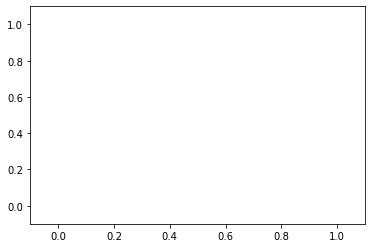

ValueError: 'c' argument has 307 elements, which is inconsistent with 'x' and 'y' with size 291.

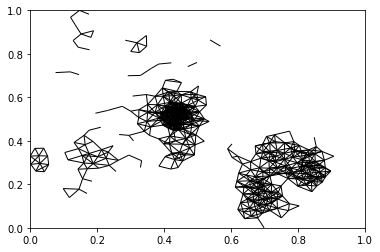

In [34]:
### Run the code below
eps_values = [0.01, 0.05, 0.1, 0.2, 0.4]

for eps in eps_values: 
    ax=plt.subplot()
    ax1=plt.subplot()
    G = nn_graph(X, eps)
    pos=nx.spring_layout(G)  
    nx.draw_networkx_edges(G,pos=X)
    nx.draw_networkx_nodes(G, pos=X, node_color=Y, node_size=20, cmap=plt.get_cmap('tab10'))
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    plt.show()


******************
The larger the epsilon value, the fewer edges are observed in the graph. This is due to the fact that the graph is constructed based on the epsilon value as a proximity threshold. The graph will construct edges to all nodes within a distance of epsilon to the initial node. As epsilon increases, there will be fewer nodes wihtin the distance of epsilon to the initial node, resulting in fewer edges being connected to the intial node. 
******************

### Task 2.1.3 (2 points)
Assign to each edge in the $\varepsilon$-neighborhood graph a weight

$$W_{i j}=e^{-\frac{\left\|\mathbf{x}_{i}-\mathbf{x}_{j}\right\|^{2}}{t}}$$

<span style='color: green'>**\[Implement\]**</span> the function ```weighted_nn_graph``` below that returns the weighted graph given the data matrix in input and the values eps and $t$, where $t$ is the parameter of the equation above. 

In [1]:
import math

def weighted_nn_graph(data, eps=20, t=0.1):
    n = len(data)
    G = nx.Graph()
    ### YOUR CODE STARTS HERE
    
    for i in data:
        for j in data:
            d= (i[0]-j[0])**2+(i[1]-j[1])**2
            if (d!=0 and d<eps**2):
                G[i][j]['weight']=math.e**(-d/t)
            else:
                G[i][j]['weight']=0
    
    ### YOUR CODE ENDS HERE
    return G

### Task 2.1.4 (2 points)

Vary $t \in \{10, 0.1, 0.000001\}$. Plot the weights as a histogram using the code below in order to analyse the results using the provided code.</br>
What happens when $t$ is very small, close to $0$, i.e., $t \rightarrow 0$?</br> What happens when $t$ is very large?
</br>Is the behaviour with $t = 0$ expected?

<span style='color: green'>**\[Motivate\]**</span> your answer reasoning on the formula. 

In [ ]:
ts = [10, 0.2, 0.07, 0.000001]
fig, ax = plt.subplots(1,4, figsize=(20, 10))
row = 0

for i, t in enumerate(ts):
    G = weighted_nn_graph(X, eps=60, t=t)
    ys = []
    

    col = i 
    for i, d in enumerate(G.edges.data()):
        ys.append(d[2]['weight'])
    plt.hist(ys, bins=100)
    ax[col].hist(ys, bins=100)
    ax[col].set_title("t: "+str(t))
    
plt.tight_layout()

******************
When $t$ is very small, close to $0$, i.e., $t \rightarrow 0$ the weight get's smaller and smaller. This due to the definition of the weight. Because it's defined as exponential dampening. The L2-norm is always non-negative and the smaller t produces bigger and bigger exponents.

When $t$ is very large the weights are also bigger due to the exponents being smaller.

This is something we expected from the formula and also see in the plots.

******************

## Task 2.2: Spectral clustering (20 points)

We will now look at spectral clustering and its properties. <br>
For this Task we will use a subgraph from [malaria_genes](https://networks.skewed.de/net/malaria_genes). <br>
Note that this dataset is the biological network of the data used in Task 2.1. <br>

### Task 2.2.1 (5 point)
Run the code below to load and visualize the network. <br> 
By only observing the below plot and the $nn$-plots (nearest-neighbor plots)of task 2.1.2, which $\varepsilon$ values seems to better approximate the real network? (just think of the answer you don't have to write something)

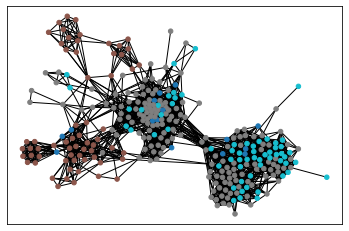

In [11]:
edgelist = read_edge_list('./data/edges.txt')
n = np.max(edgelist)+1
G = nx.Graph()
for i in range(n):
    G.add_node(i)
for edge in edgelist:
    G.add_edge(edge[0], edge[1])
pos=nx.spring_layout(G)  
nx.draw_networkx_edges(G,pos=X)
nx.draw_networkx_nodes(G, pos=X, node_color=Y, node_size=20, cmap=plt.get_cmap('tab10'))
plt.show()

Now you are having the real network, lets check how good $nn$-graph (and for which $\epsilon$ value) is a good "approximates"the real graph. <br> 

A) <span style='color: green'>**\[Implement\]**</span> a function that calculates the absolute edge difference between the real network $G$ and the one $\epsilon$-neighborhood graph. Note that in order to do that you have to follow two steps: 
1. In the first step you have to check if an edge in the real graph is also presented in the $nn$-graph, if not you increase the counter
2. In the second step you follow the opposite direction, that is you check if for every edge of the $nn$-graph if is also presented in the original one, if not you increase the counter. (Faster way just use the adjacency matrices) <br>

B) <span style='color: green'>**\[Implement\]**</span> Plot the edge-difference plot for the range of epsilon values in the range[0.01, 0.11] with step = 0.005. <br>
C) <span style='color: green'>**\[Motivate]**</span> By observing the plot it seems that there exists only one global minimum and no local minimum. Try to prove/disprove this intuition.

In [12]:
#A) YOUR CODE HERE
#Here the epsilon has to be adjusted some. 
#I'm thinking of maybe a good value might be something close to the diameter of the average clusters above
def difference(data, eps):
    counter = 0
    for edge in G.edges():
        if edge in nn_graph(data, eps, remove_self=True, directed=False):
            counter += 1
    for edge in nn_graph(data, eps, remove_self=True, directed=False).edges():
        if edge in G:
            counter += 1
    return counter
    print("The absolute difference of the edges is " + repr(counter))

difference(X, 0.1)

NameError: name 'nn_graph' is not defined

In [ ]:
#B) YOUR CODE HERE

points = np.array([])
initial = 0.01

while eps<= 0.11:
    dif = difference(X, eps)
    plt.scatter(eps,dif)
    eps+=0.005

plt.show()

******************
C) This intuition of one global and no local minimum makes sense. As we are plotting the difference of the edges as a function of epsilon there must be one epsilon value (or close to one) that produces the most similar one. Moving away from that value would always increase the difference of the edges. There is also no local minumums since this method is based on the L2-norm in epsilon neighbourhoods. It's basically a linear dependancy is imagining it in radial coordinates.
******************

In [5]:
******************
These definations of the matrices are from wikipedia. We're using these ones: 

$L_{norm}=\begin{cases} 1 &,\text{if} \; i=j \; \text{and deg isn't 0} \\ \frac{-1}{\sqrt{deg(v_i)(v_j)}} &,\text{if} \; i\neq j \; \text{and nodes are connected}\;\text{and nodes are adjacent}\\ 0 &, \text{otherwise}
\end{cases}$

$L_{rw}=\begin{cases} 1 &,\text{if} \; i=j \; \text{and deg isn't 0} \\ \frac{-1}{deg(v_i)} &,\text{if} \; i\neq j \; \text{and nodes are connected}\;\text{and nodes are adjacent}\\ 0 &, \text{otherwise}
\end{cases}$
                                                    
******************

SyntaxError: invalid syntax (<ipython-input-5-ab145d6019ed>, line 1)

### Task 2.2.2 (2 points)
Compute the eigenvectors and eigenvalues (using the provided function) of the Normalized Laplacian and the Random Walk Laplacian of the graph $G$.<br> 
Plot the spectrum (eigenvalues).

<span style='color: green'>**\[Implement\]**</span> the code to compute the different Laplacians. 

In [ ]:
def graph_eig(L): 
    """
        Takes a graph Laplacian and returns sorted the eigenvalues and vectors.
    """
    lambdas, eigenvectors = np.linalg.eig(L)
    lambdas = np.real(lambdas)
    eigenvectors = np.real(eigenvectors)
    
    order = np.argsort(lambdas)
    lambdas = lambdas[order]
    eigenvectors = eigenvectors[:, order]
    
    return lambdas, eigenvectors

In [ ]:
L_norm = None
L_rw = None

### YOUR CODE STARTS HERE

##The eigenvalue takes a matrix eg array of array


for i in X:
    nrow = []
    rwrow = []
    for j in X:
        ie = G.edges(X[i])
        je = G.edges(X[j])
        if i==j:
            nrow.append(1)
            rwrow.append(1)
        if (i!=j and X.has_edge(X[i],X[j])==true):
            nrow.append(-1/math.sqrt(ie*je))
            rwrow.append(-1/ie)
        else:
            nrow.append(0)
            rwrow.append(0)
            
    L_norm.append(nrow)
    L_rw.append(rwrow)
            


### YOUR CODE ENDS HERE

eigval_norm, eigvec_norm = graph_eig(L_norm)
eigval_rw, eigvec_rw = graph_eig(L_rw)

plt.figure(0)
plt.plot(eigval_norm, 'b-o', label='Spectrum of Normalized Laplacian', )
plt.legend()
plt.figure(1)
plt.plot(eigval_rw, 'b-o', label='Spectrum of the Random Walk Laplacian')
plt.legend()

******************
These definations of the matrices are from wikipedia. IWe're using these ones: 

$L_{norm}=\begin{cases} 1 &,\text{if} \; i=j \; \text{and deg isn't 0} \\ \frac{-1}{\sqrt{deg(v_i)(v_j)}} &,\text{if} \; i\neq j \; \text{and nodes are connected}\;\text{and nodes are adjacent}\\ 0 &, \text{otherwise}
\end{cases}$

$L_{rw}=\begin{cases} 1 &,\text{if} \; i=j \; \text{and deg isn't 0} \\ \frac{-1}{deg(v_i)} &,\text{if} \; i\neq j \; \text{and nodes are connected}\;\text{and nodes are adjacent}\\ 0 &, \text{otherwise}
\end{cases}$
******************

### Task 2.2.3 (4 points)
<span style='color: green'>**\[Implement\]**</span> the function ```spect_cluster``` that returns a vector ```y_clust``` in which each entry y_clust\[i\] represents the community assigned to node $i$. The method should be able to handle both the Normalized Laplacian, and the Random Walk Laplacian. You are allowed to use your implementation from the weekly exercises and ```sklearn.cluster.k_means``` for k-means clustering. 

In [13]:
from sklearn.cluster import k_means

def spect_cluster(G, eig_type="normal", k=5, d=5):
    ### YOUR CODE STARTS HERE
    km = k_means(k,d)
    km.fit(G)
    
    y_clust = km.labels_

    ### YOUR CODE ENDS HERE
    return y_clust #vector

In [14]:
def plot_graph(G, clusters):
    plt.figure(1,figsize=(30,15))
    nodes = G.nodes()
    ec = nx.draw_networkx_edges(G, X, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, X, nodelist=nodes, node_color=clusters, node_size=100, cmap=plt.cm.jet)

    plt.axis('off')
    plt.show()

your_clusters = spect_cluster(G, k=6)   
plot_graph(G, your_clusters)


ValueError: Expected 2D array, got scalar array instead:
array=6.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Task 2.2.4 (1 points)

Finally, use your implementation of spectral clustering with different Laplacians and different values of $k \in [2,7]$ and plot the results using the helper function ```plot_graph```. 

<span style='color: green'>**\[Describe\]**</span> the results you obtain. Especially, what is the difference between the Random Walk and the Normalized Laplacians, if any? How do you explain such differences? 

In [ ]:
for method in ['normal', 'random']: 
    for k in np.arange(2,8): 
        your_clusters = spect_cluster(G,eig_type=method, k=k)
        plot_graph(G, your_clusters)

******************
The differences between random walk and normalized Laplacians arise from the sums of the rows/colums. As seen with the definition the random walk Laplacian sum of each row is 0. This is not true for the normalized. This results the distances to be slighty smaller on the normalized data and such the characteristics of clusters are need more fine tuning. 
******************

### Task 2.2.5 (4 points)
<span style='color: green'>**\[Implement\]**</span> the modularity. Recall that the definition of modularity for a set of communities $C$ is
$$ 
Q=\frac{1}{2 m} \sum_{c \in C} \sum_{i \in c} \sum_{j \in c}\left(A_{i j}-\frac{d_{i} d_{j}}{2 m}\right) \qquad \qquad (1) 
$$
where $A$ is the adjacency matrix, and $d_i$ is the degree of node $i$

**Note**: Use ```plot_graph``` function in order to see for yourself if maximising modularity leads a better clustering. If you did not succeed with the previous Task, you are allowed to use [Scikit Learn Spectral Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

In [35]:
def modularity(G, clustering):
    modularity = 0
    ### YOUR CODE STARTS HERE
    
    m = G.number_of_edges()

    for c in set(clustering.values()):
        nodes_c = [n for n in clustering.keys() if clustering[n] == c]
        subgraph = G.subgraph(nodes_c)
        intdeg = subgraph.number_of_edges() / (2*m)
        extdeg = sum(G.degree(n) for n in nodes_c) / (2*m)
        modularity += intdeg - extdeg**2

    ### YOUR CODE ENDS HERE
    return modularity

### Task 2.2.6 (2 points)

Compute the modularity of your Spectral Clustering Implementation for different values of $k$. 

<span style='color: green'>**\[Motivate\]**</span> Which $k$ value maximizes the modularity? From your perspective, does spectral clustering forms "clear" clusters for the best $k$ found by modularity? Using the spectral graph theory, why do you think this is/isn't the case? 

In [36]:
mods = []
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for k in ks:
    clusters = spect_cluster(G, k=k) ### NOTE: If you do not use your implementation substitute with a call to the sklearn one. 
    mods.append(modularity(G, clusters))

# You may want to use plt.plot to plot the modularity for different values of k
plt.plot(ks, mods)
print(mods)

NameError: name 'spect_cluster' is not defined

******************
From my perspective, spectral clustering could form "clear" clusters for the best k found by modularity but it is not always the case as it depends on several factors.

Spectral clustering uses eigenvectors of a Laplacian graph to find low-dimensional representations of the given data to preserve its structure. The code will first construct a similarity graph and then compute the Laplacian matrix before applying eigenvalue decomposition to obtain corresponding eigenvectors to the k smallest eigenvalues. The data is then clustered into k groups based on these eigenvalues. Hence, the quality of results depends heavily on the k chosen. If k is too small, the clusters might not be well defined enough to show the structure of the data. But if k is too large, data may be overfit and there may not be any meaningful interpretation of results. Thus, when data is noisy, high-dimensional or contains overlapping clusters, spectral clustering might not be able to form "clear" clusters.

******************

### Task 2.2.7 (2 points)

<span style='color: green'>**\[Motivate\]**</span> There seems to be a relationship between graph embeddings and spectral clustering, can you guess that? _Hint_: Think to the eigenvectors of the graph's Laplacians. (1) Check the correct box below and (2) motivate your answer.

* [x] If the embeddings are linear and the similarity is the Laplacian, the embeddings we obtain minimizing the L_2 norm are equivalent to the eigenvectors of the Laplacian. 
* [ ] If the embeddings are random-walk-based embeddings, the eigenvectors of the Random Walk Laplacian are related to the embeddings obtained by such methods. 
* [ ] The relationship is just apparent. 
* [ ] If the embeddings are linear and the similarity is the Adjacency matrix, the eigenvectors of the Laplacian are equivalent to the embeddings. 

<font color='red'>IMPORTANT: Do NOT just choose one answer. Please clarify WHY this is the correct answer.</font>

******************
According the the spectral embedding theorem, the eigenvectors of the normalized Laplacian graph can be used as coordinates to embed the nodes of a graph in a low-dimensional Euclidean space. More specifically, the i-th coordinate of the embedding of node j is given by the i-th element of the eigenvector corresponding to the i-th smallest eigenvalue in the Laplacian matrix. The embeddings we obtain minimizing the L_2 norm are also equivalent to the eigenvectors of the Laplacian matrix and is also known as the Laplacian eigenmap. This is only true when similarity is based on Laplacian matrix and not for other types of embeddings or measures.
******************

# Part 3: Link analysis
In this exercise, we will work with PageRank, Random Walks and their relationships with graph properties. 
We will use the most generic definition

$$\mathbf{r} = \alpha \mathbf{Mr} + (1-\alpha)\mathbf{p}$$

with $\mathbf{r}$ the PageRank vector, $\mathbf{M}$ the weighted transition matrix, and $\mathbf{p}$ the personalization vector. 
Additionally, let $n = |V|$, where $V$ is the nodes in the graph above.
Remember that in the case of PageRank the entries of the personalization vector are $p_i = 1/n$ for all $i$.  


## Task 3.1 Approximate PageRank (10 points)

### Task 3.1.1 (3 points)

<span style='color: green'>**\[Implement\]**</span>  a different algorithm for computing Personalized PageRank. This algorithm runs a fixed number of iterations and uses the definition of random walks. 
At each step, the algorithm either selects a random neighbor with probability $\alpha$ or returns to the starting node with probability $1-\alpha$. Every time a node is visited a counter on the node is incremented by one. Initially, each counter is 0. The final ppr value is the values in the nodes divided by the number of iterations. 

In [15]:
import random
def approx_personalized_pagerank(G, node, alpha = 0.85, iterations = 1000): 
    ppr = np.zeros(G.number_of_nodes())
    ### YOUR CODE STARTS HERE
    next = node
    nn= G.number_of_nodes()-1
    
    for i in range(iterations):
        prob = random.randint(0,100)/100
        if (prob<alpha): #See if we should go to neighbour or jump
            nneigh = []
            for edge in edgelist: #let's find out where we can jump
                if (edge[0]==next):
                    nneigh.append(edge[1])
            if (len(nneigh)==0): #we should jump if there are no neighbours
                j = random.randint(0,nn) #Choose the index of a next node from the whole set
                ppr[j]+=1 #count the jump
                next = j #G[j]
                continue
            j = random.randint(0,len(nneigh)-1) #Choose the index of a next node of neighbours
            next = nneigh[j]
            ppr[next]+=1 #count the jump
            node = j #G[next] 
        else: #if we jump
            j = random.randint(0,nn) #Choose the index of a next node from the whole set
            ppr[j]+=1 #count the jump
            next = j #G[j] 
    ### YOUR CODE ENDS HERE
    return ppr

### Task 3.1.2 (3 points)

Run the ```approx_personalized_pagerank``` with default $\alpha$ and iterations $\{10, n, 2n, 4n, 100n, 1000n\}$ where $n$ is the number of nodes in the graph and starting node the node with the highest PageRank computed in Task 3.1.2.

<span style='color: green'>**\[Motivate\]**</span> what you notice as the number of iterations increase. Why are the values and the top-10 nodes ranked by PPR changing so much? 

In [ ]:
edgelist = read_edge_list('./data/edges.txt')
n = np.max(edgelist)+1
G = nx.Graph()
for i in range(n):
    G.add_node(i)
for edge in edgelist:
    G.add_edge(edge[0], edge[1])
starting_node = np.argmax(nx.pagerank(G))
for i, iterations in enumerate([10, G.number_of_nodes(), G.number_of_nodes()*2, G.number_of_nodes()*4, G.number_of_nodes()*100, G.number_of_nodes()*1000]):
    r = approx_personalized_pagerank(G, starting_node, iterations = iterations)
    r[starting_node] = 0
    r_sorted = np.argsort(r)[::-1]
    r_values = np.sort(r)[::-1]
    print(f'Iteration {iterations}: top-10 r={r_sorted[:10]}\n top-10 values={r_values[:10]}\n')

import operator
rr = nx.pagerank(G, alpha=0.85, personalization = {starting_node: 1})
rr[starting_node] = 0
r=np.zeros(len(rr))
for k in rr: r[k] = rr[k]
r_sorted = np.argsort(r)[::-1]
r_values = np.sort(r)[::-1]
print(f'top-10 r={r_sorted[:10]}\n top-10 values={r_values[:10]}\n')

******************
The frequency of the nodes start to get bit closer together. To this 10 iterations is different. For example the spread of frequencies in 307 is wider than for 307000. It also seems like the same nodes are often visited in the iterations. That makes sense since nodes that have a lot of neighbours are more probable to be chosen. 

There is a lot of variation between the rankes. When the nuber if iterations is very small the probabilistic nature of the method doesn't show. It's like tossing a coin once and concluding that the only option is the one you get. 
The bigger the number of iterations gives a more average solution for the ranks.
******************

### Task 3.1.3 (2 points)

Compare the 5 nodes with the highest PPR obtained from ```nx.pagerank(G, alpha=0.85, personalization={node_highest_pagerank: 1})``` and the one obtained by the approximation. 

<span style='color: green'>**\[Describe\]**</span> the differences. Does the number of iterations affect the results? Is there a relationship between the number of iterations and the results? Is there a relationship between the approximated value of PageRank and the real value? Do you notice anything as the number of iteration increases? 

In [ ]:
k = 5
ppr_nx = nx.pagerank(G, alpha=0.85, personalization = {starting_node: 1})
r_nx = [0 for _ in range(G.number_of_nodes())]
for k, v in ppr_nx.items():
    r_nx[k] = v
r_est = approx_personalized_pagerank(G, starting_node, alpha=0.85)

topk_nx = np.argsort(r_nx)[-5:]
topk_est = np.argsort(r_est)[-5:]

print(topk_nx, topk_est)

for iterations in [10, G.number_of_nodes(), G.number_of_nodes()*2, G.number_of_nodes()*4, G.number_of_nodes()*100, G.number_of_nodes()*1000]:
    print(f'Number of iterations {iterations}')
    ppr_nx = nx.pagerank(G, alpha=0.85, personalization = {starting_node: 1})
    r_nx = [0 for _ in range(G.number_of_nodes())]
    for k, v in ppr_nx.items():
        r_nx[k] = v
    r_est = approx_personalized_pagerank(G, starting_node, iterations = iterations, alpha=0.85)
    print(f'Approximate PPR: {r_est[:10]}')
    print(f'Real PPR: {r_nx[:10]}')
    
    
    topk_nx = np.argsort(r_nx)[-5:]
    topk_est = np.argsort(r_est)[-5:]

    print(f"Topk of nx.pagerank: {topk_nx}, Topk of our estimation {topk_est}, Size of intersection: {len(set(topk_nx).intersection(set(topk_est)))}")

*****************
It would seem that our method has some mistake left. Even by normalizing with the number of nodes the order of magniude isn't quite correct. Compared to the real one the approximate ones seem to be much closer and even. In the real one the first one seems to be quite large compared to the later ones. IT would seem that the bigger the number of iterations closet to the real one we get.
*****************

### Task 3.1.4 (2 points)

Run again the same experiment but this time use $\alpha = 0.1$. 

<span style='color: green'>**\[Motivate\]**</span> Motivate whether and why you need more or less iterations to predict the 5 nodes with the highest PPR.

In [ ]:
for iterations in [10, G.number_of_nodes(), G.number_of_nodes()*2, G.number_of_nodes()*4, G.number_of_nodes()*100]:
    ppr_nx = nx.pagerank(G, alpha=0.1, personalization = {starting_node: 1})
    r_nx = [0 for _ in range(G.number_of_nodes())]
    for k, v in ppr_nx.items():
        r_nx[k] = v
    r_est = approx_personalized_pagerank(G, starting_node, iterations = iterations, alpha=0.1)

    topk_nx = np.argsort(r_nx)[-5:]
    topk_est = np.argsort(r_est)[-5:]

    print(f"Topk of nx.pagerank: {topk_nx}, Topk of our estimation {topk_est}, Size of intersection: {len(set(topk_nx).intersection(set(topk_est)))}")
    

*****************
It would seems that method is able to catch some of the most visited nodes. It's very apparent that 10 is way too few for this data set. In this instance  the bigger iterations don't have that much difference between them. It looks that after a certain point more iterations doesn't give better results but just takes longer. So as long as the number of iterations is greater than the number of nodes the method gives a good enough approximation.
*****************

## Task 3.2 Spam and link farms (12 points)

We will now study the effect of spam in the network and construct a link farm. In this part, if you want to modify the graph, use a copy of the original graph every time you run your code, so that you do not keep adding modifications.

In [ ]:
edgelist = read_edge_list('./data/edges.txt')
n = np.max(edgelist)+1
G2 = nx.Graph()
for i in range(n):
    G2.add_node(i)
for edge in edgelist:
    G2.add_edge(edge[0], edge[1])
G = G2.copy()

### Task 3.2.1 (3 points)
Based on the analysis in the slides, construct a spam farm $s$ on the graph $G$ with $T$ fake nodes. Assume that $s$ manages to get links from node 1. With $\alpha=0.5$, 

<span style='color: green'>**\[Describe\]**</span> which is the minimum number of pages $T$ that we you need to add in order to get $s$ being assigned the highest PageRank?

In [ ]:
#CODE HERE IF YOU NEED THAT

******************
As aplha in 0.5 in half of the cases we move on to a neighbour and in half teleport. As a general principle you the highest PageRank is the node that has the most connection so T should be so that the desired node gets the biggest value. Sometimes the value doesn't have to be as big is the node already has good connections. If it's neighbour nodes are well connected T can be smaller than for a node thats neighbours have very few connections.
******************

### Task 3.2.2 (3 points)
In the above scenario, assume that $T = \frac{1}{5}$ of the nodes in the original graph. 

<span style='color: green'>**\[Motivate\]**</span> what value of $\alpha$ will maximize the PageRank $\mathbf{r}_s$ of the link farm $s$. Provide sufficient justification for your choice.

******************
A good choice would be quite a large alpha. As the fake nodes are connected to the one node s have none other edges you would end up visiting the central node s quite often. Large alpha would mean that it was more like to get more stuck in those fake edges. Large alpha means that it is more likely to jump to a neighbour node. With a small alpha there would be a lot of teleporting. That means that the node s wouldn't gain any extra probablity for the fake nodes.
******************

### Task 3.2.3 (3 points)

Now we fix both $\alpha = 0.5$ and $T = \frac{1}{5}n$. 

<span style='color: green'>**\[Implement\]**</span>  ```trusted_pagerank``` the method for spam mass estimation.

In [16]:
def trusted_pagerank(G, trusted_indices, iterations=500, alpha=0.5):
    r = None   
    ### YOUR CODE STARTS HERE
    rplus = np.zeros(G.number_of_nodes())
    next = 0
    k = random.randint(0,G.number_of_nodes()-1)
    nn = trusted_indices.number_of_nodes()-1
    
    rank = approx_personalized_pagerank(G, 0, alpha, iterations) #Get the page rank of every node
    
    for i in range(iterations): #get the pagerank when just jumping to trusted nodes
        next = random.randint(0,nn) #Choose the index of a next node from the whole set
        rplus[next]+=1 #count the jump
        node = trusted_indices[next]
            
    for i in range(len(G)):
        r[i]=(rank[i]-rplus[i])/rank[i]
    
    ### YOUR CODE ENDS HERE
    return r


### Task 3.2.4 (3 points)

<span style='color: green'>**\[Motivate\]**</span> whether we are able to detect the node $s$, if the trusted set of nodes is a random sample $10\%$ of the nodes in the original graph. 
If not, what could be a viable solution? Which nodes would you rather choose as trusted?

You are not obliged to, but you can write some helper code to reach the answer faster.  

_Hint_: Remember the spam mass formula in the Link Analysis lecture

*******************
In the solution we used the spam mass to estimate if page could be trusted. We would of course have to set some limit of what a trusted value would be. Anything with too high mass would be labeled as spam. You could also choose some deviation from a trusted value and anything that differs too much from it would be labeled as spam. 
******************

# Part 4: Graph embeddings (19 points)
In this final part, we will try a different approach for clustering the data from above. 
The strategy is going to be the following:

1. Use VERSE [[1]](https://arxiv.org/pdf/1803.04742.pdf) to produce embeddings of the nodes in the graph.
2. Use K-Means to cluster the embeddings. Measure and report NMI for the clustering. 

[[1](https://arxiv.org/pdf/1803.04742.pdf)] Tsitsulin, A., Mottin, D., Karras, P. and Müller, E., 2018, April. Verse: Versatile graph embeddings from similarity measures. In Proceedings of the 2018 World Wide Web Conference (pp. 539-548).

In [39]:
from utilities.load_data import load_mnist
import utilities.email as email
from utilities.mnist import *

from utilities.make_graphs import read_edge_list, read_list, load_data

/Users/sohfamilymacbookair13/Documents/GitHub/dm2023-exercises/handins


In [40]:
G = email.S_dir.copy()

## Task 4.1.1 (6 points)

<span style='color: green'>**\[Implement\]**</span> the methods below to compute sampling version of VERSE. _Hint:_ it might be a help to look in the original article \[1\] above.

In [57]:
from scipy.sparse import identity

def sigmoid(x):
    ''' Return the sigmoid function of x 
        x: the input vector
    '''
    ### YOUR CODE STARTS HERE
    
    x = 1 / (1 + np.exp(-x))

    ### YOUR CODE ENDS HERE
    return x

def pagerank_matrix(G, alpha = 0.85) :     
    ''' Return the Personalized PageRank matrix of a graph

        Args:
            G: the input graph
            alpha: the dumping factor of  PageRank

        :return The nxn PageRank matrix P
    '''
    ### YOUR CODE STARTS HERE
    
    n = G.number_of_nodes()
    A = np.array(nx.to_numpy_matrix(G))
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    P = alpha*np.linalg.inv(identity(n) - (1-alpha)*D/n) @ L

    ### YOUR CODE ENDS HERE
    return P
    

def update(u, v, Z, C, step_size) :
    '''Update the matrix Z using row-wise gradients of the loss function

       Args:
            u : the first node
            v : the second node
            Z : the embedding matrix
            C : the classification variable used in Noise Contrastive estimation indicating whether the sample is positive or negative
            step_size: step size for gradient descent


       :return nothing, just update rows Z[v,:] and and Z[u,:]
    '''
    ### YOUR CODE STARTS HERE
    z_u = Z[u, :]
    z_v = Z[v, :]
    y = C - sigmoid(z_u @ z_v)
    grad_u = -y * z_v
    grad_v = -y * z_u
    Z[u, :] -= step_size * grad_u
    Z[v, :] -= step_size * grad_v
    ### YOUR CODE ENDS HERE
    
    
def verse(G, S, d, k = 3, step_size = 0.0025, steps = 10000): 
    ''' Return the sampled version of VERSE

        Args:
            G: the input Graph
            S: the PageRank similarity matrix
            d: dimension of the embedding space
            k: number of negative samples
            step_size: step size for gradient descent
            steps: number of iterations

        :return the embedding matrix nxd
    '''
    n = G.number_of_nodes()
    Z = 1/d*np.random.rand(n,d)

    ### YOUR CODE STARTS HERE
    D = np.diag(np.sum(np.array(nx.to_numpy_matrix(G)), axis=1))
    L = D - np.array(nx.to_numpy_matrix(G))
    P = np.linalg.inv(D) @ L
    node_list = list(G.nodes)
    for i in range(steps):
        u = np.random.choice(node_list)
        v = np.random.choice(node_list)
        while G.has_edge(u, v):
            v = np.random.choice(node_list)
        neg_samples = np.random.choice(node_list, size=k, replace=False)
        update(u, v, Z, 1, step_size)
        for neg in neg_samples:
            update(u, neg, Z, 0, step_size)
        update(v, u, Z, 1, step_size)
        for neg in neg_samples:
            update(v, neg, Z, 0, step_size)
    ### YOUR CODE ENDS HERE
    return Z

In [58]:
# This code runs the `verse` algorithm above on G and stores the embeddings to 'verse.npy'
P   = pagerank_matrix(G)
emb = verse(G, P, 128, step_size=0.0025, steps=10_000)
np.save('verse.npy', emb)

### Task 4.1.2 (3 points)

<span style='color: green'>**\[Implement\]**</span> a small piece of code that runs $k$-means on the embeddings with $k \in [2,7]$ to evaluate the performance compared to Spectral clustering using the NMI as measure. You can use ```sklearn.metrics.normalized_mutual_info_score``` for the NMI and ```sklearn.cluster.KMeans``` for kmeans. In both cases, you can use your own implementation from Handin 1 or the exercises, but it will not give you extra points.  

<span style='color: green'>**\[Describe\]**</span> which of the method performs the best and whether the results show similarities between the two methods

In [61]:
### YOUR CODE STARTS HERE
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import normalized_mutual_info_score

# i'm not really sure how to do this one T.T i keep getting an error code :( 

S = pagerank_matrix(G)
emb = verse(G, S, d=16)

nmi_kmeans = []
nmi_spectral = []
for k in range(2, 8):
    kmeans_labels = KMeans(n_clusters=k).fit_predict(emb)
    spectral_labels = SpectralClustering(n_clusters=k, affinity='nearest_neighbors').fit_predict(emb)
    nmi_kmeans.append(normalized_mutual_info_score(list(nx.get_node_attributes(G, 'club').values()), kmeans_labels))
    nmi_spectral.append(normalized_mutual_info_score(list(nx.get_node_attributes(G, 'club').values()), spectral_labels))

print("NMI scores for k-means: ", nmi_kmeans)
print("NMI scores for spectral clustering: ", nmi_spectral)


### YOUR CODE ENDS HERE

ValueError: Found input variables with inconsistent numbers of samples: [0, 156]

*******************
<span style="color:red">**YOUR ANSWER HERE**</span>
******************

### Task 4.1.3 (2 points)

<span style='color: green'>**\[Motivate\]**</span> how you would conceptionally expand the way of embedding a graph, if you had a multi-label-graph. E.g. meaning you have multiple labels and each edge needs to have exacrly one of those. So you can also have multiple edges between the same nodes, as long as they have different labels.

*******************
<span style="color:red">I would use a multi-label embedding technique such as using a multi-label extension of the node2vec algorithm or using a graph convolutional network (GCN).</span>
******************

## Task 4.2 (8 points)

**This is a hard exercise. Do it for fun or only if you are done with easier questions.**

<span style='color: green'>**\[Implement\]**</span> a new GCN that optimizes for modularity. The loss function takes in input a matrix $C \in \mathbb{R}^{n\times k}$ of embeddings for each of the nodes. 
$C$ represents the community assignment matrix, i.e. each entry $C_{ij}$ contains the probability that node $i$ belong to community $j$. 

The loss function is the following
$$
loss = - Tr(C^\top B C) + l\|C\|_2
$$ 
where $B$ is the modularity matrix that you will also implement, and $l$ is a regularization factor controlling the impact of the $L_2$ regularizer. 
We will implement a two-layer GCN similar to the one implemented in the exercises, but the last layer's activation fucntion is a Softmax. 

In [ ]:
import pykeen

# Adjacency matrix
G     = email.S_undir.copy()
A     = np.array(nx.adj_matrix(G, weight=None).todense())
I     = np.eye(A.shape[0])
A     = A + I # Add self loop

# Degree matrix
### YOUR CODE HERE

# Normalized Laplacian
    
# Create input vectors

### TODO your code here

X = torch.tensor(X, dtype=torch.float, requires_grad=True) # Indicate to pytorch that we need gradients for this variable
As = torch.tensor(A, dtype=torch.float)
L = torch.tensor(L, dtype=torch.float)  # We don't need to learn this so no grad required.

In [ ]:
# Define a GCN
class GCNLayer(nn.Module):
    def __init__(self, L, input_features, output_features, activation=F.relu):
        """
            Inputs:
                L:               The "Laplacian" of the graph, as defined above
                input_features:  The size of the input embedding
                output_features: The size of the output embedding 
                activation:      Activation function sigma
        """
        super().__init__()
        
        ### TODO Your code here

        
        ### TODO Your code here
     
    def forward(self, X):
        ### TODO Your code here

        
        ### TODO Your code here
        return X

Define the modularity matrix and the modularity loss

In [ ]:
def modularity_matrix(A):
    B = None
    ### YOUR CODE HERE

    ### YOUR CODE HERE
    return torch.tensor(B, dtype=torch.float)

def modularity_loss(C, B, l = 0.01): 
    ''' Return the modularity loss

        Args:
            C: the node-community affinity matrix
            B: the modularity matrix
            l: the regularization factor
            
        :return the modularity loss as described at the beginning of the exercise
    '''
    loss = 0
    ### YOUR CODE HERE

    
    ### YOUR CODE HERE
    return loss

Compute labels from communities

In [ ]:
### Compute labels from communities
labels = None
### YOUR CODE HERE


### YOUR CODE HERE


Create the model

In [ ]:
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Encode the labels with one-hot encoding
def to_categorical(y):
    """ 1-hot encodes a tensor """
    num_classes = np.unique(y).size
    return np.eye(num_classes, dtype='uint8')[y]

def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

y, classes = encode_label(labels)
y = torch.tensor(y)

# Define convolutional network
in_features, out_features = X.shape[1], classes.size # output features as many as the number of classes
hidden_dim = 16

# Stack two GCN layers as our model
# nn.Sequential is an implicit nn.Module, which uses the layers in given order as the forward pass
gcn = nn.Sequential(
    GCNLayer(L, in_features, hidden_dim),
    GCNLayer(L, hidden_dim, out_features, None),
    nn.Softmax(dim=1)
)
gcn.to(device)

Train the unsupervised model once 

In [ ]:
l = 100
epochs = 2000

def train_model(model, optimizer, X, B, epochs=100, print_every=10, batch_size = 2):
    for epoch in range(epochs+1):
        y_pred = model(X)
        loss = modularity_loss(y_pred, B, l=l)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            print(f'Epoch {epoch:2d}, loss={loss.item():.5f}')

B = modularity_matrix(A)
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
train_model(gcn, optimizer, X, B, epochs=epochs, print_every=100)

Evaluate your model using NMI. Since the initialization is random train the model 10 times and take the average NMI. Assign each node to the community with the highest probability. 
You should obtain an Average $\text{NMI}\approx0.5$.

Plot the last graph with the nodes colored by commnitieis communities using ```plot_graph``` below. 

**Note**: You have to create the model 5 times otherwise you are keeping training the same model's parameters! 

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score

def plot_graph(G, y_pred): 
    plt.figure(1,figsize=(15,5))
    pos = nx.spring_layout(G)
    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=y_pred, node_size=100, cmap=plt.cm.jet)
    plt.axis('off')
    plt.show()


    
### YOUR CODE STARTS HERE 


### YOUR CODE ENDS HERE